In [19]:
import  pandas as pd

import matplotlib.pyplot as plt
import klib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_excel("../data/raw/entrenamiento.xlsx")
df = df.rename(columns={"C7.1": "C8", "des": "QUALITY"})
features = df.columns[:-1]
df.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,QUALITY
0,6.8,0.190620,0.307485,18.1,46.00,32.0,4.897840,1.00000,3.27,0.392042,8.8,5
1,6.2,0.246860,NaN,5.0,43.00,50.0,5.241747,0.99318,3.23,0.494696,10.8,6
2,6.7,0.350657,0.329304,12.1,0.04,61.0,5.517453,0.99794,3.31,0.457425,9.7,5
3,6.8,0.254642,0.405465,13.3,53.00,48.0,5.273000,0.99740,3.09,0.371564,9.4,5
4,6.6,0.215111,0.239017,15.8,35.00,46.0,5.241747,0.99820,3.24,0.412110,9.2,5


## Ouliers

In [4]:
# Correct the values in column C8 that are above 900 by dividing them by 1000
high_values = df["C8"] > 900
df.loc[high_values, "C8"] = df.loc[high_values, "C8"] / 1000

# Display the basic statistics of the corrected column
df["C8"].describe()

count    3646.000000
mean        0.994044
std         0.003008
min         0.987110
25%         0.991760
50%         0.993800
75%         0.996100
max         1.038980
Name: C8, dtype: float64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
C1,3684.0,6.857166,0.846430,3.800000,6.300000,6.800000,7.300000,14.200000
C2,3664.0,0.421440,0.988207,0.076961,0.190620,0.231112,0.285179,6.913737
C3,3648.0,0.284054,0.086887,0.000000,0.239017,0.277632,0.329304,0.802002
C4,3636.0,6.424642,5.084063,0.600000,1.700000,5.300000,9.900000,65.800000
C5,3659.0,40.685294,25.106022,0.020000,33.000000,41.000000,49.000000,346.000000
C6,3655.0,35.216142,17.167346,2.000000,23.000000,34.000000,46.000000,289.000000
C7,3645.0,4.885591,0.341723,2.302585,4.691348,4.912655,5.129899,6.089045
C8,3646.0,0.994044,0.003008,0.987110,0.991760,0.993800,0.996100,1.038980
C9,3658.0,3.188291,0.152155,2.720000,3.090000,3.180000,3.280000,3.820000
C10,3639.0,0.395421,0.074535,0.198851,0.343590,0.385262,0.438255,0.732368


## Tratamiento de outliers

In [6]:
# Function to impute outliers using IQR and column median
def impute_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    
    # Impute outliers with the median of the column
    data.loc[outliers, column] = data[column].median()
    return data

# Impute outliers in the dataset using IQR method
df_imputed_outliers = df.copy()
for column in df.columns:
    if df[column].dtype != 'object':  # Apply only for numerical columns
        df_imputed_outliers = impute_outliers_iqr(df_imputed_outliers, column)

# Display basic statistics of the dataset after outlier imputation
df_imputed_outliers.describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,QUALITY
count,3684.000000,3664.000000,3648.000000,3636.000000,3659.000000,3655.000000,3645.000000,3646.000000,3658.000000,3639.000000,3658.000000,3918.000000
mean,6.810016,0.235175,0.280678,6.390058,42.117245,34.541176,4.903080,0.994025,3.182701,0.390783,10.491607,5.807300
std,0.744556,0.061220,0.066104,4.951515,9.325894,15.412465,0.300378,0.002898,0.140424,0.066773,1.218126,0.763862
min,4.800000,0.076961,0.104360,0.600000,9.000000,2.000000,4.043051,0.987110,2.820000,0.207014,8.000000,4.000000
25%,6.300000,0.190620,0.239017,1.700000,36.000000,23.000000,4.709530,0.991760,3.090000,0.343590,9.400000,5.000000
50%,6.800000,0.231112,0.277632,5.300000,41.000000,34.000000,4.912655,0.993800,3.180000,0.385262,10.300000,6.000000
75%,7.300000,0.270027,0.314811,9.900000,47.000000,45.000000,5.129899,0.996100,3.270000,0.431782,11.300000,6.000000
max,8.800000,0.425268,0.463734,22.000000,73.000000,80.000000,5.749393,1.002400,3.560000,0.576613,14.000000,7.000000


In [32]:
df_imputed_outliers

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,QUALITY
0,6.8,0.190620,0.307485,18.1,46.0,32.0,4.897840,1.00000,3.27,0.392042,8.8,5
1,6.2,0.246860,0.277632,5.0,43.0,50.0,5.241747,0.99318,3.23,0.494696,10.8,6
2,6.7,0.350657,0.329304,12.1,41.0,61.0,5.517453,0.99794,3.31,0.457425,9.7,5
3,6.8,0.254642,0.405465,13.3,53.0,48.0,5.273000,0.99740,3.09,0.371564,9.4,5
4,6.6,0.215111,0.239017,15.8,35.0,46.0,5.241747,0.99820,3.24,0.412110,9.2,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3913,7.7,0.231112,0.215111,11.2,31.0,41.0,5.123964,0.99480,3.12,0.357674,11.3,7
3914,8.1,0.378436,0.270027,1.7,52.0,50.0,5.214936,0.99230,3.03,0.350657,11.2,5
3915,6.1,0.148420,0.254642,6.0,41.0,29.0,4.976734,0.99474,3.18,0.378436,10.7,6
3916,8.2,0.239017,0.329304,7.8,41.0,49.0,5.342334,0.99760,3.31,0.412110,9.5,6


## Imputacion de valores faltantes

In [7]:
# Calculate the number of missing values in each column
missing_values = df_imputed_outliers.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

C1     234
C2     254
C3     270
C4     282
C5     259
C6     263
C7     273
C8     272
C9     260
C10    279
C11    260
dtype: int64

In [8]:
# Impute missing values using median for predictor columns (excluding 'des' or 'QUALITY')
for column in df_imputed_outliers.columns:
    if column != "des" and df_imputed_outliers[column].dtype != 'object':  # Exclude target column and non-numerical columns
        median_value = df_imputed_outliers[column].median()
        df_imputed_outliers[column].fillna(median_value, inplace=True)

# Check if there are any missing values left
remaining_missing_values = df_imputed_outliers.isnull().sum()
remaining_missing_values[remaining_missing_values > 0]

Series([], dtype: int64)

In [12]:
df_imputed_outliers.isna().sum()

C1         0
C2         0
C3         0
C4         0
C5         0
C6         0
C7         0
C8         0
C9         0
C10        0
C11        0
QUALITY    0
dtype: int64

In [35]:
df_completed = df_imputed_outliers.copy()

In [40]:
df_completed.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,QUALITY
0,6.8,0.190620,0.307485,18.1,46.0,32.0,4.897840,1.00000,3.27,0.392042,8.8,5
1,6.2,0.246860,0.277632,5.0,43.0,50.0,5.241747,0.99318,3.23,0.494696,10.8,6
2,6.7,0.350657,0.329304,12.1,41.0,61.0,5.517453,0.99794,3.31,0.457425,9.7,5
3,6.8,0.254642,0.405465,13.3,53.0,48.0,5.273000,0.99740,3.09,0.371564,9.4,5
4,6.6,0.215111,0.239017,15.8,35.0,46.0,5.241747,0.99820,3.24,0.412110,9.2,5


## Seleccion de caracteristicas => Correlacion

In [14]:
# Calculate the correlation of each feature with the target variable "des"
correlation_with_target = df_imputed_outliers.corr()["QUALITY"].sort_values(ascending=False)

# Drop the "des" correlation with itself
correlation_with_target = correlation_with_target.drop("QUALITY")

In [21]:
correlation_with_target

C11    0.389832
C9     0.105163
C10    0.031181
C6     0.027012
C3     0.019531
C1    -0.075961
C4    -0.094360
C2    -0.136625
C7    -0.160526
C5    -0.230048
C8    -0.291863
Name: QUALITY, dtype: float64

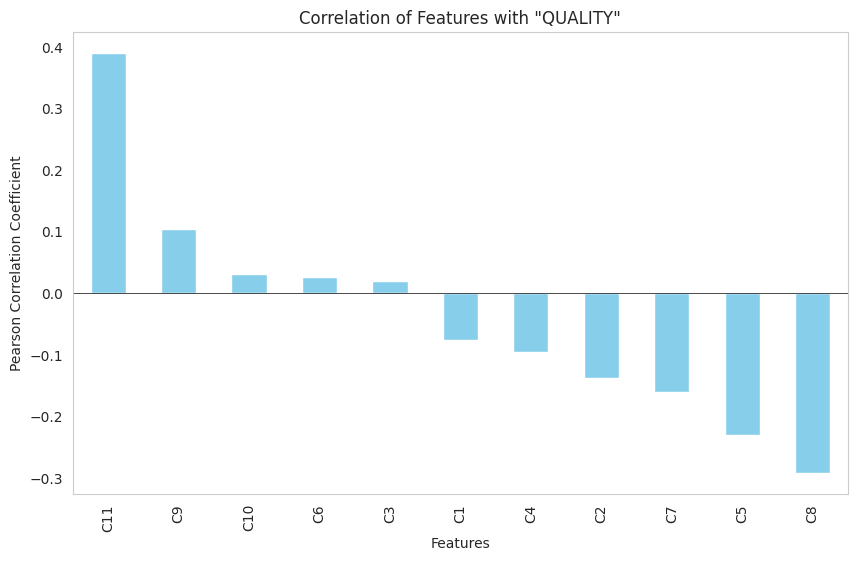

In [22]:
# Plot the correlation values again
plt.figure(figsize=(10, 6))
correlation_with_target.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with "QUALITY"')
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel('Features')
plt.axhline(0, color='black', linewidth=0.5)
plt.grid()
plt.show()


### Random Forest => Correlacion

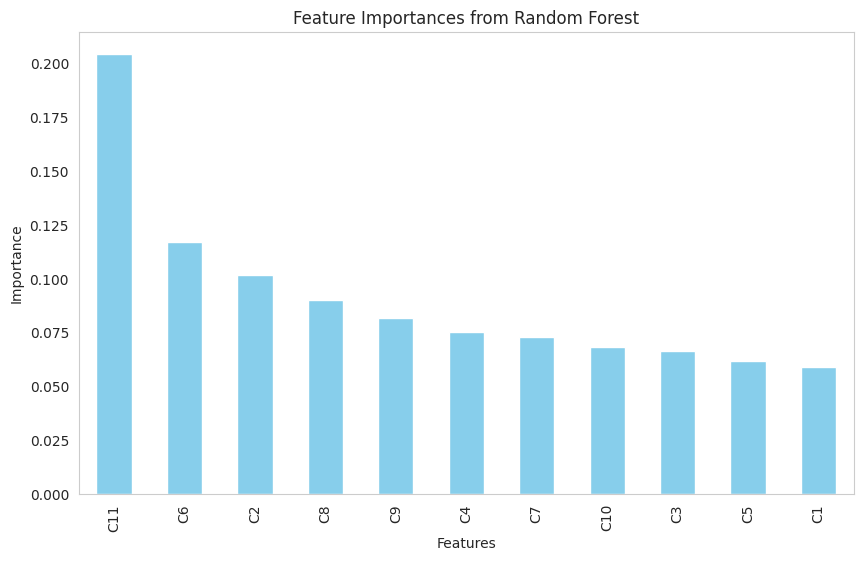

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Splitting the data into features (X) and target (y)
X = df_completed.drop(columns=["QUALITY"])
y = df_completed["QUALITY"]

# Create and train a Random Forest model
rf_model_single_block = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_single_block.fit(X, y)

# Extract feature importances
feature_importances_single_block = rf_model_single_block.feature_importances_

# Create a DataFrame to visualize the feature importances
features_df_single_block = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances_single_block
})

# Sort the DataFrame by importance
features_df_single_block = features_df_single_block.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
features_df_single_block.set_index('Feature').plot(kind='bar', legend=False, ax=plt.gca(), color='skyblue')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.grid()
plt.show()


## Splitting the DataFrame

In [66]:
# Adjusting the column names and splitting the data
X = df_completed.drop(columns=["QUALITY"])
y = df_completed["QUALITY"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Linear Regression

In [67]:
# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test)

# Calculate MAE
lr_mae = mean_absolute_error(y_test, lr_predictions)
print(f'MAE of Linear Regression = {lr_mae:.4f}')

MAE of Linear Regression = 0.5195


## Ridge Regression

In [48]:
from sklearn.linear_model import Ridge
X_train_completed, X_test_completed, y_train_completed, y_test_completed = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # alpha is the regularization strength
ridge_model.fit(X_train_completed, y_train_completed)

# Predict on the test set
ridge_predictions = ridge_model.predict(X_test_completed)

# Calculate MAE for Ridge Regression
ridge_mae = mean_absolute_error(y_test_completed, ridge_predictions)
print(f'MAE of Ridge Regression: {ridge_mae:.4f}')

MAE of Ridge Regression: 0.5234


## Lasso Regression

In [52]:
from sklearn.linear_model import Lasso

# Lasso Regression
lasso_model = Lasso(alpha=0.1)  # alpha is the regularization strength
lasso_model.fit(X_train_completed, y_train_completed)

# Predict on the test set
lasso_predictions = lasso_model.predict(X_test_completed)

# Calculate MAE for Lasso Regression
lasso_mae = mean_absolute_error(y_test_completed, lasso_predictions)
print(f'MAE of Lasso Regression: {lasso_mae:.4f}')

MAE of Lasso Regression: 0.5345


## Decision Tree 

In [55]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Regression
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_completed, y_train_completed)

# Predict on the test set
dt_predictions = dt_model.predict(X_test_completed)

# Calculate MAE for Decision Tree Regression
dt_mae = mean_absolute_error(y_test_completed, dt_predictions)
print(f'MAE of Decision Tree Regression: {dt_mae:.4f}')

MAE of Decision Tree Regression: 0.5655


## Random Forest

In [69]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_completed, y_train_completed)

# Predict on the test set
rf_predictions = rf_model.predict(X_test_completed)

# Calculate MAE for Random Forest Regression
rf_mae = mean_absolute_error(y_test_completed, rf_predictions)
print(f'MAE of Random Forest Regression: {rf_mae:.4}')

MAE of Random Forest Regression: 0.4546


## Gradient Boosting

In [61]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_completed, y_train_completed)

# Predict on the test set
gb_predictions = gb_model.predict(X_test_completed)

# Calculate MAE for Gradient Boosting Regression
gb_mae = mean_absolute_error(y_test_completed, gb_predictions)
print(f'MAE of Gradient Boosting Regression: {gb_mae:.4}')

MAE of Random Forest Regression: 0.4976


## KNN

In [62]:
from sklearn.neighbors import KNeighborsRegressor

# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_completed, y_train_completed)

# Predict on the test set
knn_predictions = knn_model.predict(X_test_completed)

# Calculate MAE for K-Nearest Neighbors Regression
knn_mae = mean_absolute_error(y_test_completed, knn_predictions)
print(f'MAE of KNN: {knn_mae:.4}')

MAE of KNN: 0.5639


## Comparative

In [65]:
# Creating a dictionary with MAE values for each model
mae_values = {
    "Linear Regression": lr_mae,
    "Ridge Regression": ridge_mae,
    "Lasso Regression": lasso_mae,
    "Decision Tree Regression": dt_mae,
    "Random Forest": rf_mae,
    "Gradient Boosting": gb_mae,
    "K-Nearest Neighbors": knn_mae
}

# Convert the dictionary to a pandas DataFrame for better visualization
mae_comparison = pd.DataFrame(list(mae_values.items()), columns=["Model", "MAE"]).sort_values(by="MAE")
mae_comparison

,Model,MAE
4,Random Forest,0.454575
5,Gradient Boosting,0.497578
0,Linear Regression,0.519546
1,Ridge Regression,0.523414
2,Lasso Regression,0.534534
6,K-Nearest Neighbors,0.563946
3,Decision Tree Regression,0.565476
